# Optimization Example for Interim Operational Capability 1

## Set up.

### Import packages.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath("../src"))

In [2]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import seaborn           as sb
import tyche             as ty

from copy            import deepcopy
from IPython.display import Image 

In [3]:
import cProfile
import timeit

## Load data.

### The data are stored in a set of tab-separated value files in a folder.

In [4]:
designs = ty.Designs("data")

In [5]:
investments = ty.Investments("data")

### Compile the production and metric functions for each technology in the dataset.

In [6]:
designs.compile()

## Evaluate the tranches of investments.

In [7]:
tranche_results = investments.evaluate_tranches(designs, sample_count=250)

### Examine the results of investments in tranches.

In [8]:
tranche_results.summary

Value          Units
Category   Tranche      Sample Index                                 
CIGS       CIGS 0       1      Capital       -0.966941         Δ$/Wdc
                               Efficiency     0.210833          %/100
                               GHG           -0.000449  ΔgCO2e/system
                               Hazardous      0.050154          g/kWh
                               LCOE          -0.039973         Δ$/kWh
...                                                ...            ...
Soft Costs Soft Costs 2 250    Hazardous      0.245665          g/kWh
                               LCOE           0.015854         Δ$/kWh
                               Lifetime      25.000310             yr
                               Strategic      0.000000          g/kWh
                               Yield       1278.417125          hr/yr

[48000 rows x 2 columns]

### Join those results to investment levels.

In [9]:
results = investments.tranches.join(tranche_results.summary)
results

Amount Notes  \
Category   Tranche      Scenario     Sample Index                         
CIGS       CIGS 0       CIGS 0       1      Capital           0.0         
                                            Efficiency        0.0         
                                            GHG               0.0         
                                            Hazardous         0.0         
                                            LCOE              0.0         
...                                                           ...   ...   
Soft Costs Soft Costs 2 Soft Costs 2 250    Hazardous   5000000.0         
                                            LCOE        5000000.0         
                                            Lifetime    5000000.0         
                                            Strategic   5000000.0         
                                            Yield       5000000.0         

                                                              Value  \
Category   Tranche      Scenario     Sample Index                     
CIGS       CIGS 0       CIGS 0       1      Capital       -0.966941   
                                            Efficiency     0.210833   
                                            GHG           -0.000449   
                                            Hazardous      0.050154   
                                            LCOE          -0.039973   
...                                                             ...   
Soft Costs Soft Costs 2 Soft Costs 2 250    Hazardous      0.245665   
                                            LCOE           0.015854   
                                            Lifetime      25.000310   
                                            Strategic      0.000000   
                                            Yield       1278.417125   

                                                                Units  
Category   Tranche      Scenario     Sample Index                      
CIGS       CIGS 0       CIGS 0       1      Capital            Δ$/Wdc  
                                            Efficiency          %/100  
                                            GHG         ΔgCO2e/system  
                                            Hazardous           g/kWh  
                                            LCOE               Δ$/kWh  
...                                                               ...  
Soft Costs Soft Costs 2 Soft Costs 2 250    Hazardous           g/kWh  
                                            LCOE               Δ$/kWh  
                                            Lifetime               yr  
                                            Strategic           g/kWh  
                                            Yield               hr/yr  

[48000 rows x 4 columns]

#### Plot the result of investment in each category upon each metric.

##### Individual observations:

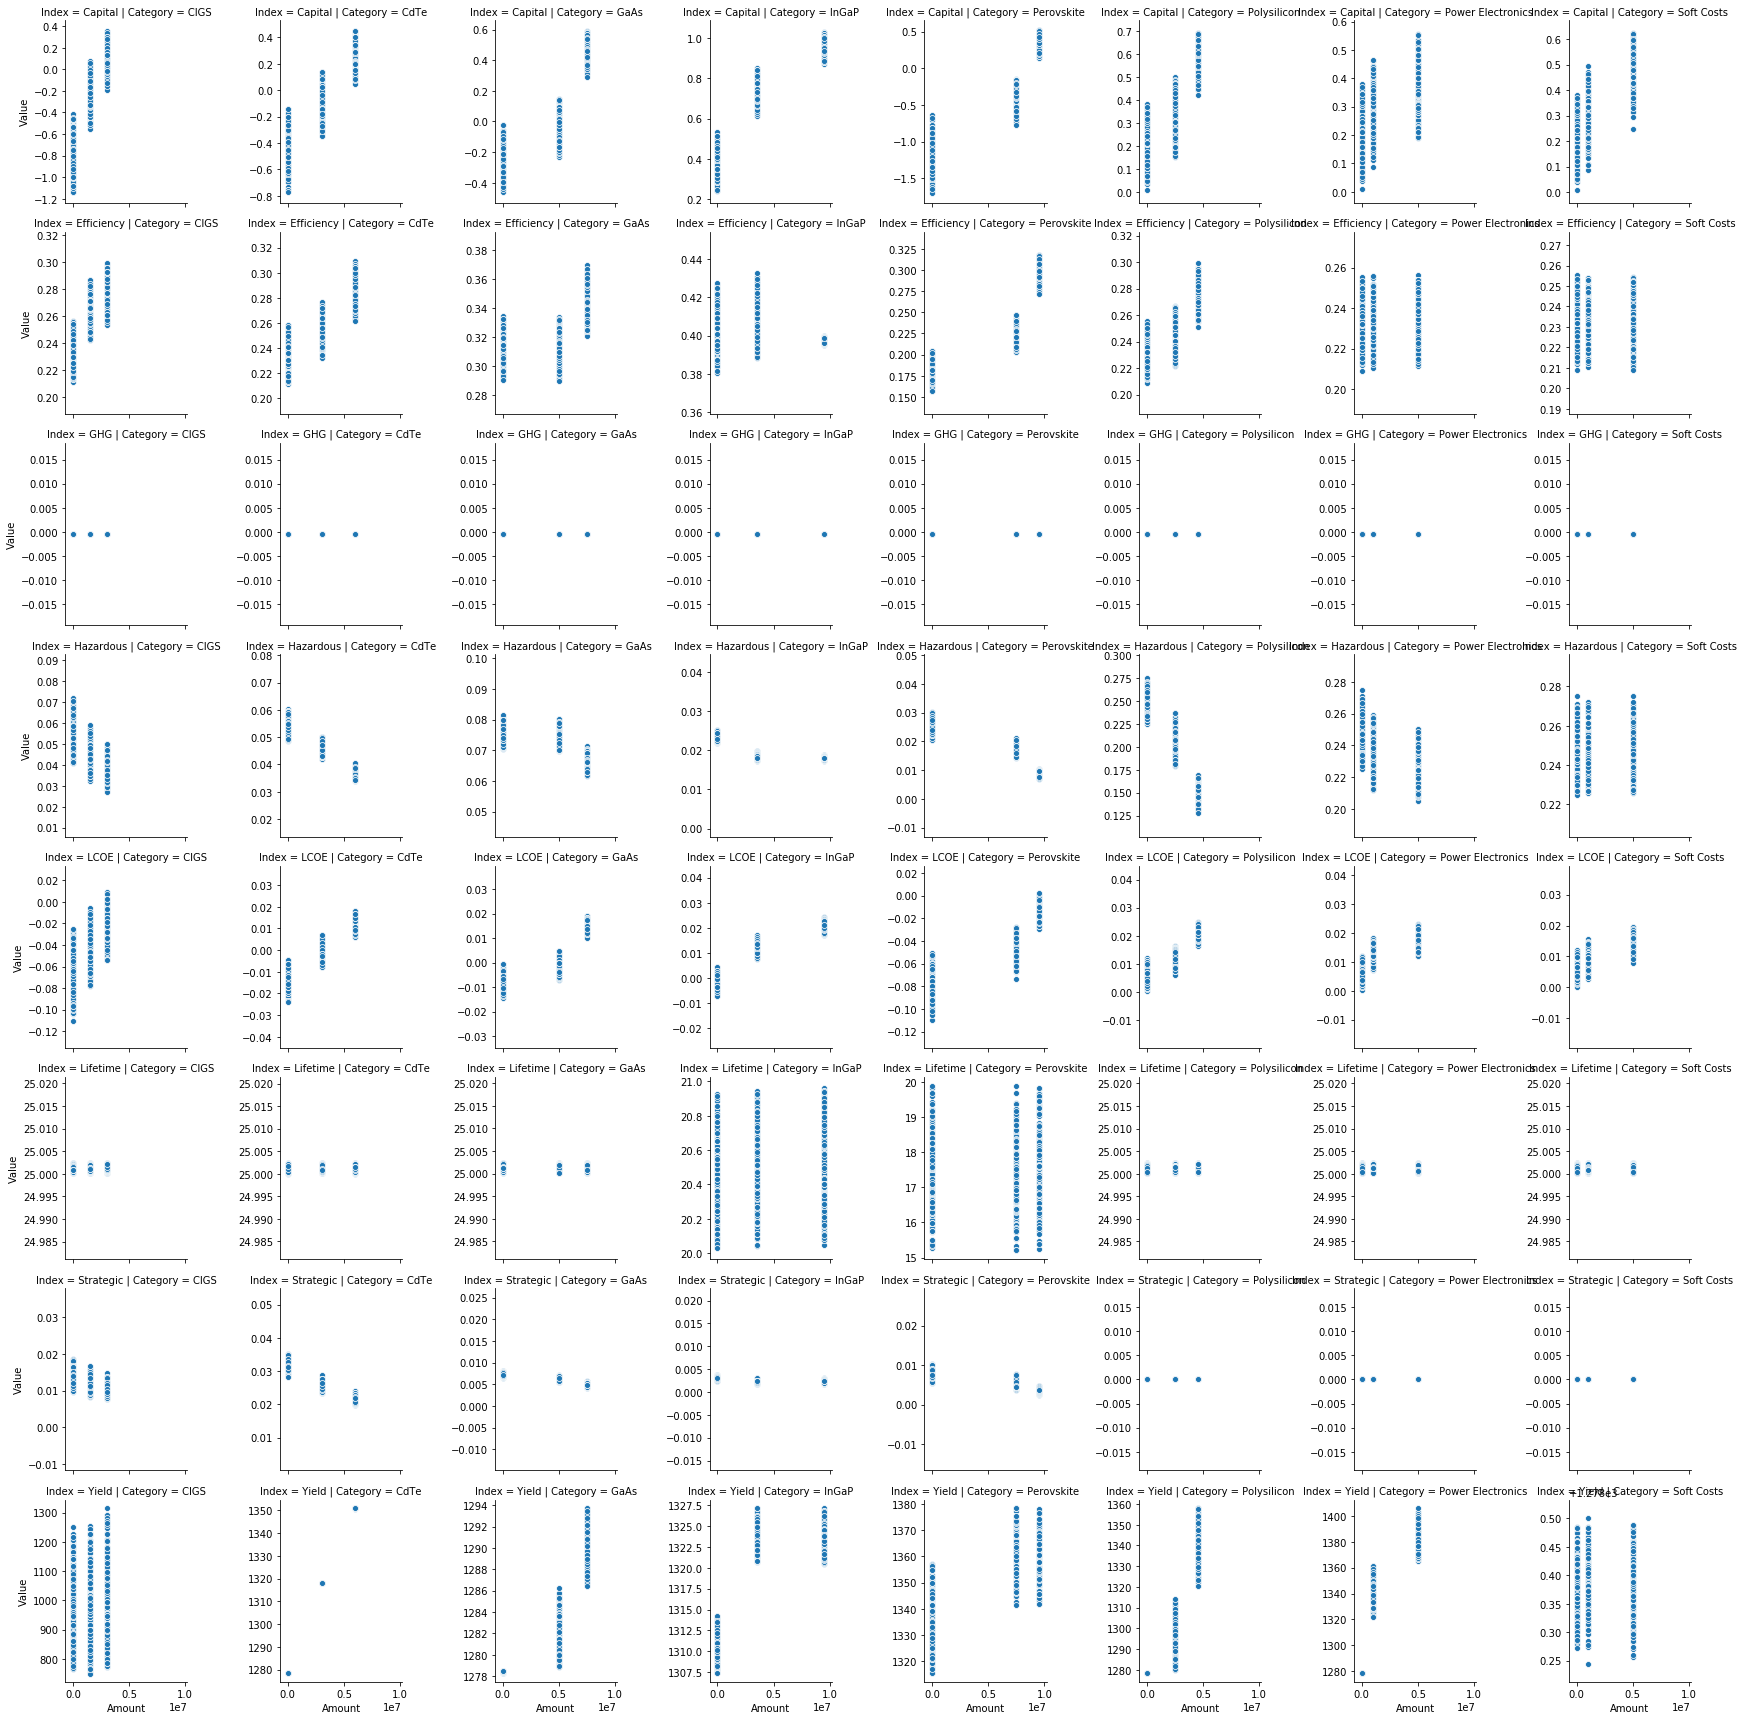

In [10]:
g = sb.FacetGrid(results.reset_index(), col="Category",  row="Index", sharey=False)
g.map(sb.scatterplot, "Amount", "Value")

##### Quantiles:

/nix/store/2hqyq1p29z76wvh920r43a63sy9n1cag-python3-3.7.6-env/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


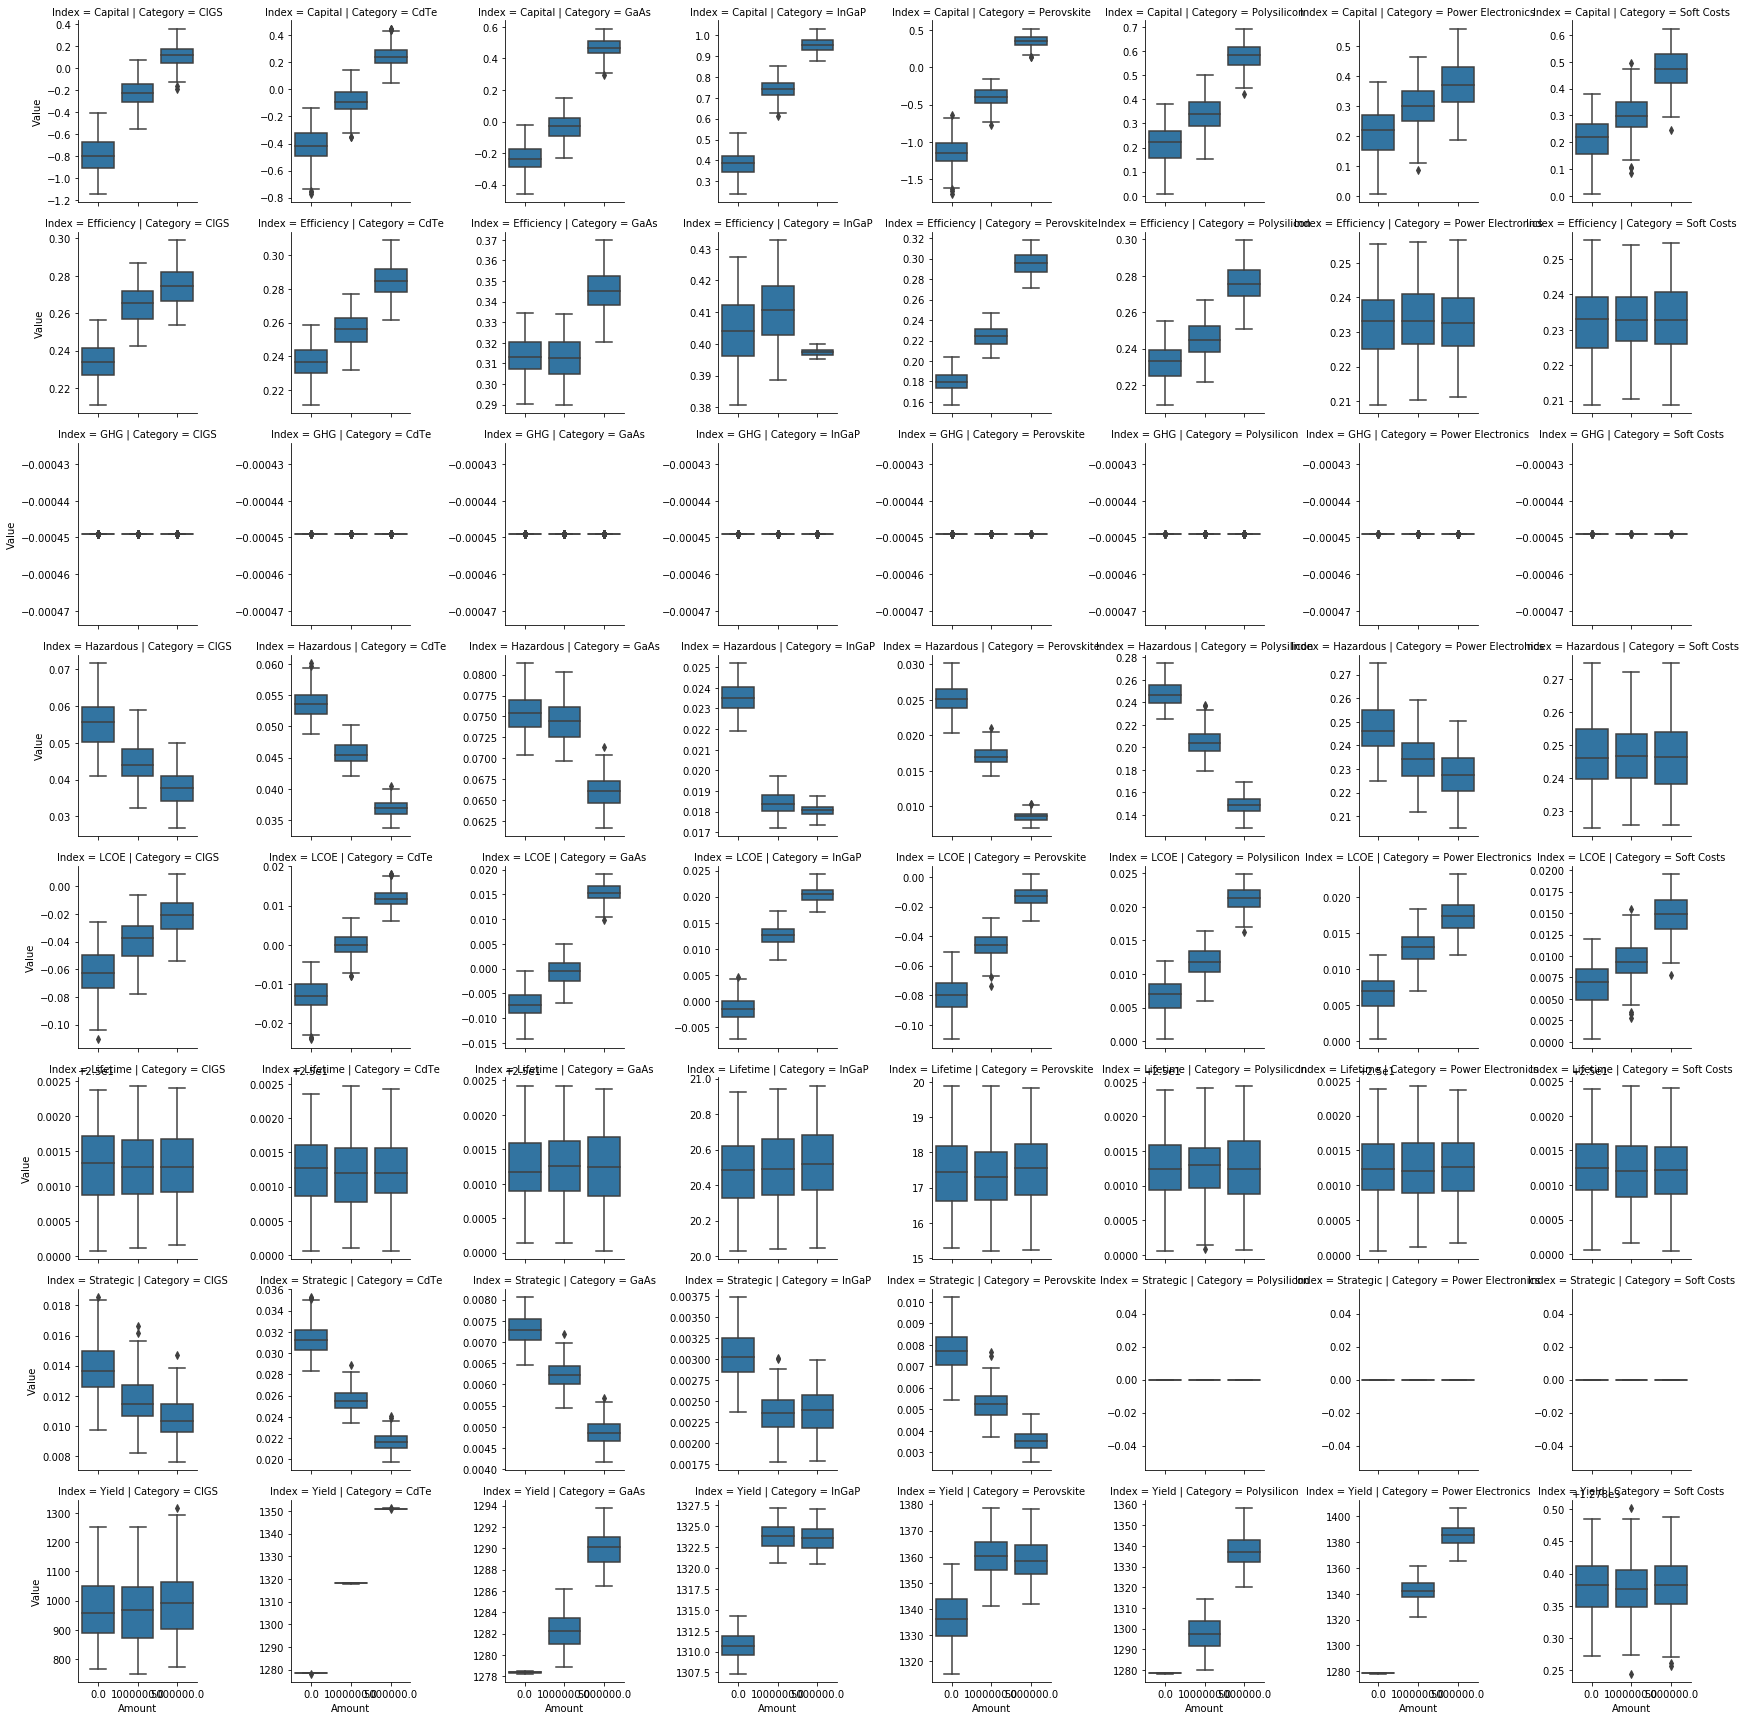

In [11]:
g = sb.FacetGrid(results.reset_index(), col="Category",  row="Index", sharey=False)
g.map(sb.boxplot, "Amount", "Value")

## Create an evaluator to interpolate investments.

In [12]:
evaluator = ty.Evaluator(investments.tranches, tranche_results.summary)

### Maximum investment amounts, by category.

In [13]:
evaluator.max_amount

,Amount
Category,
CIGS,3000000.0
CdTe,6000000.0
GaAs,7500000.0
InGaP,9500000.0
Perovskite,9500000.0
Polysilicon,4500000.0
Power Electronics,5000000.0
Soft Costs,5000000.0


### Range of metrics.

In [14]:
evaluator.min_metric.rename(columns = {"Value" : "Minimum"}).join(
    evaluator.max_metric.rename(columns = {"Value" : "Maximum"})
)

,Minimum,Maximum
Index,,
Capital,-3.802971,4.824875
Efficiency,1.875690,2.540355
GHG,-0.003592,-0.003592
Hazardous,0.704660,1.093718
LCOE,-0.265400,0.139501
Lifetime,185.237441,190.868522
Strategic,0.035825,0.075851
Yield,9764.270304,10708.721097


## ε-Constraint multiobjective optimization

### Create an optimizer.

In [15]:
optimizer = ty.EpsilonConstraintOptimizer(evaluator)

### Optimize on a single metric.

In [16]:
optimum = optimizer.maximize_slsqp(
    "LCOE",
    max_amount = evaluator.max_amount.Amount,
    verbose = 2,
)
optimum.exit_message

  NIT    FC           OBJFUN            GNORM
    1    10     1.224052E-01     1.863616E-02
    2    20     1.220579E-01     1.863616E-02
    3    30     1.203214E-01     1.863616E-02
    4    40     1.116387E-01     1.863616E-02
    5    50     7.559500E-02     1.414391E-02
    6    60     7.102437E-02     1.414391E-02
    7    70     7.090694E-02     1.414391E-02
    8    80     7.031979E-02     1.414390E-02
    9    90     6.747964E-02     1.397700E-02
   10   100     5.402917E-02     1.397700E-02
   11   110     5.249435E-03     1.404673E-02
   12   120     5.099472E-03     1.404673E-02
   13   130     4.349662E-03     1.404673E-02
   14   140     6.006110E-04     1.404673E-02
   15   150    -3.238568E-02     2.108677E-02
   16   160    -3.561757E-02     2.108677E-02
   17   170    -4.187344E-02     2.108677E-02
   18   180    -4.331357E-02     2.108677E-02
   19   190    -4.520152E-02     2.108677E-02
   20   200    -4.524489E-02     2.108677E-02
   21   210    -4.529226E-02     2

'Optimization terminated successfully.'

#### Optimal investment amounts:

In [17]:
optimum.amounts

Category
CIGS                 3.000000e+06
CdTe                 6.000000e+06
GaAs                 7.500000e+06
InGaP                9.500000e+06
Perovskite           9.500000e+06
Polysilicon          4.500000e+06
Power Electronics    5.000000e+06
Soft Costs           5.000000e+06
Name: Amount, dtype: float64

#### Values of metrics at optimal investment:

In [18]:
optimum.metrics

Index
Capital           3.550464
Efficiency        2.340161
GHG              -0.003592
Hazardous         0.790736
LCOE              0.065657
Lifetime        188.066208
Strategic         0.043012
Yield         10319.785143
Name: Value, dtype: float64

### Time the code.

In [19]:
timeit.timeit(lambda: optimizer.maximize_slsqp("LCOE", max_amount = evaluator.max_amount.Amount), number=1)

6.161067922832444

### Profile the code to see where it is slow.

In [20]:
cProfile.run('optimizer.maximize_slsqp("LCOE", max_amount = evaluator.max_amount.Amount)')

         13290364 function calls (13133588 primitive calls) in 9.334 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(any)
       34    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(append)
       66    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argsort)
      342    0.000    0.000    0.005    0.000 <__array_function__ internals>:2(array_equal)
       69    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(asfarray)
      103    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(atleast_1d)
       73    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(bincount)
      349    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(can_cast)
        2    0.000  

        1    0.000    0.000    0.000    0.000 frame.py:4573(<listcomp>)
        7    0.000    0.000    0.000    0.000 frame.py:515(axes)
      341    0.000    0.000    0.002    0.000 frame.py:532(shape)
        2    0.000    0.000    0.005    0.003 frame.py:5736(groupby)
      341    0.001    0.000    6.734    0.020 frame.py:6731(apply)
      341    0.002    0.000    0.547    0.002 frame.py:7088(join)
      341    0.003    0.000    0.545    0.002 frame.py:7212(_join_compat)
      341    0.000    0.000    0.000    0.000 frame.py:8084(_get_agg_axis)
    21824    0.004    0.000    0.004    0.000 fromnumeric.py:1270(_searchsorted_dispatcher)
    21824    0.021    0.000    0.092    0.000 fromnumeric.py:1274(searchsorted)
       34    0.000    0.000    0.000    0.000 fromnumeric.py:1689(_ravel_dispatcher)
       34    0.000    0.000    0.000    0.000 fromnumeric.py:1693(ravel)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2017(_clip_dispatcher)
        2    0.000    0.000    0

      342    0.001    0.000    0.016    0.000 ops.py:890(slabels)
      342    0.000    0.000    0.008    0.000 ops.py:895(sort_idx)
     3069    0.009    0.000    0.508    0.000 ops.py:900(__iter__)
      343    0.001    0.000    0.063    0.000 ops.py:913(_get_sorted_data)
     2728    0.002    0.000    0.419    0.000 ops.py:921(_chop)
        1    0.000    0.000    0.016    0.016 ops.py:926(fast_apply)
      342    0.001    0.000    0.001    0.000 ops.py:940(get_splitter)
        1    0.000    0.000    0.000    0.000 optimize.py:139(_check_unknown_options)
        2    0.000    0.000    0.000    0.000 optimize.py:320(wrap_function)
   374/68    0.001    0.000    9.267    0.136 optimize.py:325(function_wrapper)
       64    0.000    0.000    0.000    0.000 polyint.py:105(_reshape_yi)
       64    0.000    0.000    0.002    0.000 polyint.py:113(_set_yi)
       64    0.000    0.000    0.000    0.000 polyint.py:133(_set_dtype)
       64    0.000    0.000    0.002    0.000 polyint.py:55(_

In [21]:
evaluate = evaluator.make_statistic_evaluator()
cProfile.run('evaluate(evaluator.max_amount.Amount)')

         38721 function calls (38270 primitive calls) in 0.035 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(array_equal)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(can_cast)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(cumsum)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(min_scalar_type)
      128    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(ndim)
        9    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(putmask)
       64    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(searchsorted)
        9    0.00

        1    0.000    0.000    0.002    0.002 merge.py:639(get_result)
        1    0.000    0.000    0.000    0.000 merge.py:718(_maybe_restore_index_levels)
        1    0.000    0.000    0.000    0.000 merge.py:753(_maybe_add_join_keys)
        1    0.000    0.000    0.000    0.000 merge.py:844(_get_join_info)
        1    0.000    0.000    0.000    0.000 merge.py:929(_get_merge_keys)
       13    0.000    0.000    0.001    0.000 missing.py:132(_isna_new)
       10    0.000    0.000    0.000    0.000 missing.py:225(_isna_ndarraylike)
        2    0.000    0.000    0.000    0.000 missing.py:402(array_equivalent)
       13    0.000    0.000    0.001    0.000 missing.py:49(isna)
       24    0.000    0.000    0.000    0.000 multi.py:1175(__len__)
       29    0.000    0.000    0.000    0.000 multi.py:1178(_get_names)
       10    0.000    0.000    0.000    0.000 multi.py:1181(_set_names)
        1    0.000    0.000    0.001    0.001 multi.py:1243(_get_grouper_for_level)
        1    0.